In [1]:
#Importing the important libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import seaborn as sns
import splitfolders
import os.path

from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy import argmax
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import adam_v2
from keras.layers import RandomFlip, RandomRotation, RandomZoom, Input, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input

### Data Augmentation

In [3]:
#Before Data Augmentation, n = 167, blast = 72, blight = 95
#After Data Augmentation, n = 600 blast = 300, blight = 300
import Augmentor
p = Augmentor.Pipeline('C:/Users/mlini/Thesis/data/processedFinal/blight')
p.zoom(probability=0.3, min_factor=0.8, max_factor=1.5)
p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
p.flip_left_right(probability=1)
p.skew(probability=1, magnitude=1)
#p.sample(300)

Initialised with 95 image(s) found.
Output directory set to C:/Users/mlini/Thesis/data/processedFinal/blight\output.

Processing <PIL.Image.Image image mode=RGB size=300x300 at 0x1FE15113C10>: 100%|██████████| 300/300 [00:01<00:00, 165.63 Samples/s] 


### Split Train and Testing Dataset 

In [130]:
input_folder = 'data/bigdataset/'

In [132]:
#Organize augmented dataset to train and testing folder
splitfolders.ratio(input_folder, output = "data/datasetFinal",
                   seed=42, ratio=(.9,.1))

Copying files: 600 files [00:00, 691.32 files/s]


### File Naming

In [42]:
#Change file names to their respective classes, blight/blast
path = './data/d/'
files = os.listdir(path)
p = 1
for index, file in enumerate(files):
    os.rename(os.path.join(path, file), os.path.join(path, ''.join(['blb_Tangalan,Aklan_', str(index + p), '.jpg'])))

### Build ResNet50 Model

In [2]:
#Provide the dataset directory
data_dir = 'data/datasetFinal/train'

In [3]:
# Declare input shape of images to fit the Model
img_height, img_width = 224, 224
# Number of training examples utilized in one iteration
batch_size = 32

In [4]:
classnames = ['blast', 'blight']

### 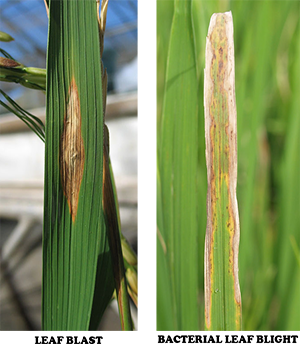

In [6]:
#Download the architecture of ResNet50 with ImageNet weights, use declared input shape, declare average pooling and num of class
resnet_model = Sequential()
pretrained_model = tf.keras.applications.ResNet50(
    include_top = False,
    input_shape = (img_height, img_width, 3),
    # Calculates the average for each patch of the feature map
    pooling = 'avg',
    classes = 2,
    weights = 'imagenet'
)
# Add pretrained_model to Sequential resnet
resnet_model.add(pretrained_model)

## 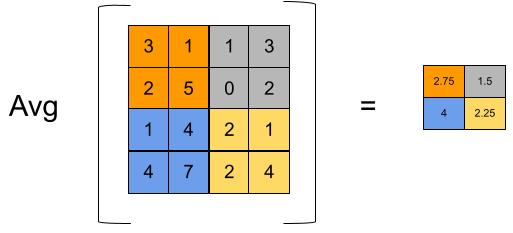

In [7]:
# Adding a dropout layer to drop 20% of nodes(neurons), avoids overfitting
resnet_model.add(Dropout(0.2))
# Adding a fully connected layer having 1024 neurons
resnet_model.add(Dense(1024, activation='relu'))
# Adding a fully connected layer having 2 neurons which will
# give the probability of image having either blast or blight
resnet_model.add(Dense(2, activation='softmax'))

#Training only top layers i.e. the layers which we have added in the end
for layer in pretrained_model.layers:
    layer.trainable = False
    

In [8]:
#print a useful summary of the model includes: Name and type of all layers in the model.
#Output shape for each layer
#Number of weight parameters of each layer
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 25,687,938
Trainable params: 2,100,226
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
# Creating objects for image augmentations
data_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    validation_split=0.1
)
train_gen = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 459 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [10]:
# Compiling the model
resnet_model.compile(
    
    optimizer = adam_v2.Adam(learning_rate = 0.0001),
    # loss function for multi-class classification model where the output label is assigned integer value (0, 1, 2, 3…)
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
#Training the model for 10 epochs
history = resnet_model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = 3
)

Epoch 1/3
15/15 [==============================] - 26s 318ms/step - loss: 0.6719 - accuracy: 0.6710 - val_loss: 0.4336 - val_accuracy: 0.8235
Epoch 2/3
15/15 [==============================] - 2s 125ms/step - loss: 0.2658 - accuracy: 0.9063 - val_loss: 0.3264 - val_accuracy: 0.8431
Epoch 3/3
15/15 [==============================] - 2s 124ms/step - loss: 0.1498 - accuracy: 0.9739 - val_loss: 0.2371 - val_accuracy: 0.9608


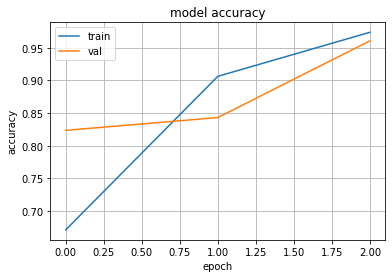

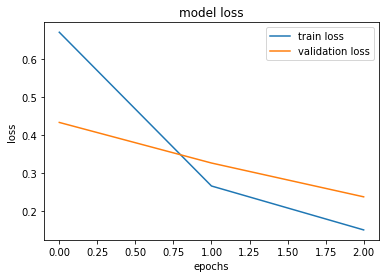

In [12]:
#Plot model accuracy
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()

#Plot model loss

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'])

plt.show()

In [38]:
#Checks first to see if file exists already
#if not, the model is saved to disk.
if os.path.isfile('data/models/resnet50.h5') is False:
    resnet_model.save('data/models/resnet50.h5')

In [6]:
# Load previous models
resnet_model = keras.models.load_model('data/models/resnet50.h5')

## Confusion Matrix

In [39]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [40]:
#Generate Testing Dataset to fit the Model
test_generator = test_gen.flow_from_directory(
        './data/datasetFinal/test/',
        target_size=(img_height, img_width),
        shuffle = False,
        class_mode='categorical',
        batch_size=1)


Found 120 images belonging to 2 classes.


In [32]:
# Check number of test data
filenames = test_generator.filenames
nb_samples = len(filenames)

In [33]:
#Predicting the generated test data and appending the results to array
predict = resnet_model.predict(test_generator,steps = nb_samples)
pp = []
for i in predict:
  pp.append(np.argmax(i))

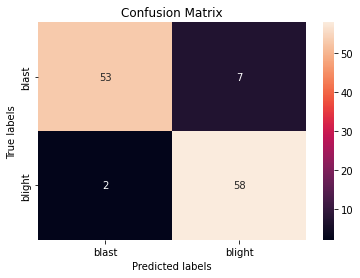

In [34]:
#Create the confusion matrix using the test data and the result of prediction
cf = confusion_matrix(test_generator.classes, pp)
ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax)

## labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['blast', 'blight']); ax.yaxis.set_ticklabels(['blast', 'blight']);

## Accuracy, Recall, Precision

In [35]:
#Calculate testing data accuracy score
accuracy_score(test_generator.classes, pp)

0.925

In [36]:
#Print precision and recall for test data
print(classification_report(test_generator.classes, pp, target_names=classnames))

              precision    recall  f1-score   support

       blast       0.96      0.88      0.92        60
      blight       0.89      0.97      0.93        60

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.92       120
weighted avg       0.93      0.93      0.92       120



###  Gradio package to demo the ml model

In [41]:
import gradio as gr

In [42]:
# Function for predicting uploaded images
def predict_image(img):
  classnames = ['blast', 'blight']
  image = img
  image_resized = cv2.resize(image, (img_height, img_width))
  image = np.expand_dims(image_resized, axis=0)
  pred = resnet_model.predict(image)[0]
  return {classnames[i]: float(pred[i]) for i in range(2)}

In [43]:
#Create Gradio Interface
image = gr.inputs.Image(shape=(244,244))
label = gr.outputs.Label(num_top_classes=2)
gr.Interface(fn=predict_image, 
             title='Rice Leaf Disease Detection',
             description='Bacterial Leaf Blight v Leaf Blast',
             allow_flagging='manual', 
             inputs="image",
             flagging_dir="data/flag",
             outputs="label").launch(share=True)

Running on local URL:  http://127.0.0.1:7861/
Running on public URL: https://53721.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x279106df280>,
 'http://127.0.0.1:7861/',
 'https://53721.gradio.app')